# Classification

## General overview
In this homework you will learn how to implement and test simple neural network models for solving supervised problems. It is divided in two tasks.

* **Regression task**: 
the regression model will consist in a simple function approximation problem, similar to the one discussed during the Lab practices. 

* **Classification task**: 
the classification model will consist in a simple image recognition problem, where the goal is to correctly classify images of Zalando's article images (Fashion MNIST). 

In both cases, but especially for the classification problem, you should explore the use of advanced optimizers and regularization methods (e.g., initialization scheme, momentum, ADAM, early stopping, L2, L1 / sparsity, dropout…) to improve convergence of stochastic gradient descent and promote generalization. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. For the image classification task, you can also implement more advanced convolutional architectures and explore feature visualization techniques to better understand how the deep network is encoding information at different processing layers.


## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	2 pt: implement basic regression and classification tasks
*	2 pt: explore advanced optimizers and regularization methods (both tasks)
*	1 pt: optimize hyperparameters using grid/random search and cross-validation (both tasks)
*	2 pt: implement CNN for classification task
*	1 pt: visualize weight histograms, activation profiles and receptive fields


## Guidelines

* The goal is to train a neural network that maps an input image (from fashionMNIST) to one of ten classes (multi-class classification problem with mutually exclusive classes).
* Define a proper loss (e.g. [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))
* Also here, consider to create a validation set from you training data, or use a k-fold cross-validation strategy.
* Pay attention to the shape, data type and output values range. If needed, modify them accordingly to your implementation (read carefully the documentation of the layers that you use, e.g. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)).
* Explore different optimizers, acivation functions, network architectures. Analyze the effect of different regularization methods, such as dropout layers, random transformations (image rotation, scaling, add noise...) or L2 regularization (weight decay).

In [1]:
## Import 
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch import nn


import os
import torch
from torch import nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
from sklearn.model_selection import KFold

In [2]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


## Dataset prof

Download the dataset:

In [ ]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)

How to get an image and the corresponding label:

SAMPLE AT INDEX 0
LABEL: 9


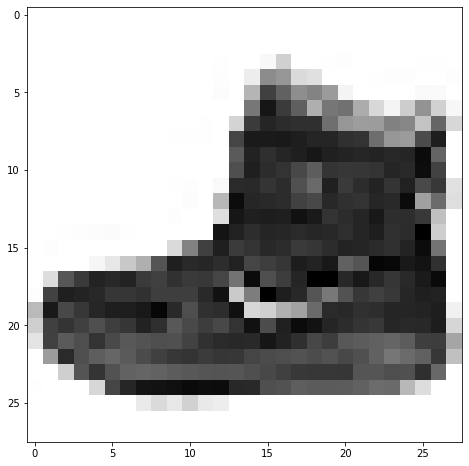

In [4]:
sample_index = 0
image = train_dataset[sample_index][0]
label = train_dataset[sample_index][1]

fig = plt.figure(figsize=(8,8))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

The output of the dataset is a PIL Image, a python object specifically developed to manage and process images. PyTorch supports this format, and there are useful transforms available natively in the framework: https://pytorch.org/docs/stable/torchvision/transforms.html

If you want, you can easily convert a PIL image to a numpy array and entirely ignore the PIL object:

In [5]:
image_numpy = np.array(image)

print(f'Numpy array shape: {image_numpy.shape}')
print(f'Numpy array type: {image_numpy.dtype}')

Numpy array shape: (28, 28)
Numpy array type: uint8


To transform a PIL Image directly to a PyTorch tensor, instead:

In [6]:
to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(image)

print(f'PyTorch tensor shape: {image_tensor.shape}')
print(f'PyTorch tensor type: {image_tensor.dtype}')

PyTorch tensor shape: torch.Size([1, 28, 28])
PyTorch tensor type: torch.float32


#Dataset

In [ ]:
#Obtain the validation dataset 
#train_size= int(0.8*len(train_dataset))
#val_size = len(train_dataset)-train_size
#print(train_size,val_size)
#train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
#Dataloader

38400 9600


In [3]:
dataset_transforms = transforms.Compose([transforms.ToTensor(),
#                                    transforms.Normalize((0.1307,), (0.3081,))
                                     ])

#Could define 
#train_trasform with random noise, rotation ecc.
#to add to dataset_trasform for the training data.

In [4]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, transform=dataset_transforms,download=True)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, transform=dataset_transforms, download=True) 

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw



In [5]:
train_dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: classifier_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [6]:
test_dataset

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: classifier_data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

# Model

In [80]:
class SimpleConvNet(nn.Module):
  '''
    Simple Convolutional Neural Network
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Conv2d(1, 10, kernel_size=3),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(26 * 26 * 10, 50),
      nn.ReLU(),
      nn.Linear(50, 20),
      nn.ReLU(),
      nn.Linear(20, 10)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

# Training

In [46]:
def training(self, device, loss_fn, optimizer, num_epochs, trainloader):
  
    # Initialize optimizer
    #optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
    optimizer = optimizer
    train_loss = []

    # Run the training loop for defined number of epochs
    for epoch in range(0, num_epochs):
  
      # Print epoch
      #print(f'Starting epoch {epoch+1}')

      # Iterate over the DataLoader for training data
      for i, data in enumerate(trainloader, 0):

        inputs = data[0].to(device)
        targets = data[1].to(device)
        out = self(inputs)
        loss = loss_fn(out,targets)
        self.zero_grad()
        loss.backward()
        optimizer.step()

        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)
            
    # Process is complete.
    #print('Training process has finished. Saving trained model.')
    
    # Saving the model
    #save_path = f'./model-fold-{fold}.pth'
    #torch.save(network.state_dict(), save_path)
    return train_loss

def evaluate(self, device, loss_fn, optimizer, num_epochs, vloader, fold):
  val_loss = []
  correct = 0
  total = 0

  # For fold results
  results = {}

  self.eval()
  with torch.no_grad():
    for i, data in enumerate(vloader, 0):

        inputs = data[0].to(device)
        targets = data[1].to(device)
        out = self(inputs)
        loss = loss_fn(out,targets)
        # Save train loss for this batch
        loss_val = loss.detach().cpu().numpy()
        val_loss.append(loss_val)

        # Set total and correct
        _, predicted = torch.max(out.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    #Print accuracy
    print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
    print('--------------------------------')
    results[fold] = 100.0 * (correct / total)
    return val_loss, results




In [33]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   #The hasattr() method returns true if an object has the given named attribute and false if it does not
   # hasttr(object,name)
   if hasattr(layer, 'reset_parameters'):
    #print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()


In [47]:
def kfold_validation(dataset, network):
    k_folds = 2
    num_epochs = 1
    loss_function = nn.CrossEntropyLoss()
    dataset = dataset

    # Define the K-fold Cross Validator
    kfold = KFold(n_splits=k_folds, shuffle=True)

    # K-fold Cross Validation model evaluation
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
      # Print
      print(f'FOLD {fold}')
      print('--------------------------------')
      # Sample elements randomly from a given list of ids, no replacement.
      train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
      test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
      # Define data loaders for training and testing data in this fold
      trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, sampler=train_subsampler)
      testloader = torch.utils.data.DataLoader(dataset,batch_size=10, sampler=test_subsampler)
      # Init the neural network
      #network = SimpleConvNet()
      #network.to(device)
      network.apply(reset_weights)
      # Initialize optimizer
      optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
      #This is the training loop then!
      #Could call a training loop function!
      #print(trainloader)
      train_loss = training(network, device, loss_function, optimizer, 2, trainloader)
      val_loss, results = evaluate(network, device, loss_function, optimizer, 2, testloader, fold)

    #Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
      print(f'Fold {key}: {value} %')
      sum += value
    print(f'Average: {sum/len(results.items())} %')
    average = sum/len(results.items())

    return average, train_loss, val_loss




In [35]:
#kfold_validation(train_dataset)

# Optuna with manual kfold cross validation ... define the training loop inside the study ...

In [ ]:
! pip install optuna

In [12]:
import optuna
import torch.optim as optim

In [127]:
def training(self, device, loss_fn, optimizer, num_epochs, trainloader):
  
    # Initialize optimizer
    #optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
    optimizer = optimizer
    train_loss_log = []

    # Run the training loop for defined number of epochs
    for epoch in range(0, num_epochs):
      train_loss = []
      # Print epoch
      #print(f'Starting epoch {epoch+1}')

      # Iterate over the DataLoader for training data
      for i, data in enumerate(trainloader, 0):

        inputs = data[0].to(device)
        targets = data[1].to(device)
        out = self(inputs)
        loss = loss_fn(out,targets)
        self.zero_grad()
        loss.backward()
        optimizer.step()

        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)

      #Save average train loss
      train_loss = np.mean(train_loss)
      print(f"AVERAGE TRAIN LOSS: {train_loss}")
      train_loss_log.append(train_loss)

            
    # Process is complete.
    #print('Training process has finished. Saving trained model.')
    
    # Saving the model
    #save_path = f'./model-fold-{fold}.pth'
    #torch.save(network.state_dict(), save_path)
    return train_loss_log

def evaluate(self, device, loss_fn, optimizer, num_epochs, vloader, fold):
  val_loss_log = []
  correct = 0
  total = 0

  # For fold results
  results = {}

  # Run the training loop for defined number of epochs
  for epoch in range(0, num_epochs):
    val_loss = []
  
    self.eval()
    with torch.no_grad():
      for i, data in enumerate(vloader, 0):
      
          inputs = data[0].to(device)
          targets = data[1].to(device)
          out = self(inputs)
          loss = loss_fn(out,targets)
  
          # Save train loss for this batch
          loss_val = loss.detach().cpu().numpy()
          val_loss.append(loss_val)
  
          # Set total and correct
          _, predicted = torch.max(out.data, 1)
          total += targets.size(0)
          correct += (predicted == targets).sum().item()
  
      # Save average validation loss
      val_loss = np.mean(val_loss)
      print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
      val_loss_log.append(val_loss)
  
      #Print accuracy
      print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
      print('--------------------------------')
      results[fold] = 100.0 * (correct / total)
      return val_loss, results






In [59]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   #The hasattr() method returns true if an object has the given named attribute and false if it does not
   # hasttr(object,name)
   if hasattr(layer, 'reset_parameters'):
    #print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [129]:
def kfold_validation(dataset, network, trial):
    k_folds = 2
    num_epochs = 1
    loss_function = nn.CrossEntropyLoss()
    dataset = dataset

    # Define the K-fold Cross Validator
    kfold = KFold(n_splits=k_folds, shuffle=True)

    # K-fold Cross Validation model evaluation
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
      # Print
      print(f'FOLD {fold}')
      print('--------------------------------')
      # Sample elements randomly from a given list of ids, no replacement.
      train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
      test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
      # Define data loaders for training and testing data in this fold
      trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, sampler=train_subsampler)
      testloader = torch.utils.data.DataLoader(dataset,batch_size=10, sampler=test_subsampler)
      # Init the neural network
      #network = SimpleConvNet()
      #network.to(device)
      network.apply(reset_weights)
      # Initialize optimizer
      optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
      #This is the training loop then!
      #Could call a training loop function!
      #print(trainloader)
      train_loss = training(network, device, loss_function, optimizer, 2, trainloader)
      val_loss, results = evaluate(network, device, loss_function, optimizer, 2, testloader, fold)

      #Problema return é per tutte le fold ...cosí ritorno l'ultima
      print(train_loss)
      print(val_loss)
      
    #Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
      print(f'Fold {key}: {value} %')
      sum += value
    print(f'Average: {sum/len(results.items())} %')
    average = sum/len(results.items())

    return average, train_loss, val_loss

In [111]:
class SimpleConvNet(nn.Module):
  '''
    Simple Convolutional Neural Network
  '''
  def __init__(self, trial):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Conv2d(1, 10, kernel_size=3),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(26 * 26 * 10, 50),
      nn.ReLU(),
      nn.Linear(50, 20),
      nn.ReLU(),
      nn.Linear(20, 10)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

  

#def define_model(trial):
#    # We optimize the number of layers, hidden units and dropout ratio in each layer.
#    n_layers = trial.suggest_int("n_layers", 1, 3)
#    layers = []
#
#    in_features = 28 * 28
#    for i in range(n_layers):
#        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)
#        layers.append(nn.Linear(in_features, out_features))
#        layers.append(nn.ReLU())
#        p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
#        layers.append(nn.Dropout(p))
#
#        in_features = out_features
#    layers.append(nn.Linear(in_features, 10))
#    layers.append(nn.LogSoftmax(dim=1))
#
#    return nn.Sequential(*layers)


In [130]:
def objective(trial):

  model = SimpleConvNet(trial).to(device)

  # Generate the optimizers.
  optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
  lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
  optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

  #Dovrei aggiungere train_dataset  ???

  accuracy, train_loss, val_loss  = kfold_validation(train_dataset, model, trial)

  trial.set_user_attr("train", train_loss)
  #trial.set_user_attr("v1", v1)

  return accuracy

In [131]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1, timeout=600)

[I 2022-06-19 14:30:18,926] A new study created in memory with name: no-name-63cf5c26-40a5-4ae8-b686-45cd88e2c514


FOLD 0
--------------------------------
AVERAGE TRAIN LOSS: 0.7467410564422607
AVERAGE TRAIN LOSS: 0.47548556327819824
AVERAGE VAL LOSS: 0.4450688362121582
Accuracy for fold 0: 84 %
--------------------------------
[0.74674106, 0.47548556]
0.44506884
FOLD 1
--------------------------------
AVERAGE TRAIN LOSS: 0.7634961605072021
AVERAGE TRAIN LOSS: 0.4720650315284729


[I 2022-06-19 14:31:04,734] Trial 0 finished with value: 84.68333333333334 and parameters: {'optimizer': 'Adam', 'lr': 0.0004516151349593968}. Best is trial 0 with value: 84.68333333333334.


AVERAGE VAL LOSS: 0.4393118917942047
Accuracy for fold 1: 84 %
--------------------------------
[0.76349616, 0.47206503]
0.4393119
K-FOLD CROSS VALIDATION RESULTS FOR 2 FOLDS
--------------------------------
Fold 1: 84.68333333333334 %
Average: 84.68333333333334 %


In [132]:
df = study.trials_dataframe()
df

,number,value,datetime_start,datetime_complete,duration,params_lr,params_optimizer,user_attrs_train,state
0,0,84.683333,2022-06-19 14:30:18.931092,2022-06-19 14:31:04.734376,0 days 00:00:45.803284,0.000452,Adam,"[0.76349616, 0.47206503]",COMPLETE


In [134]:
#df.user_attrs_train[0]
print(len(df.user_attrs_train[0]))
print(df.user_attrs_train)
#df.user_attrs_train.values()

#ltrain_tr1 = [i for i in df.user_attrs_train[0] ]
ltrain_tr2 = [i for i in df.user_attrs_train[1] ]
print(len(ltrain_tr1))

2
0    [0.76349616, 0.47206503]
Name: user_attrs_train, dtype: object


KeyError: ignored

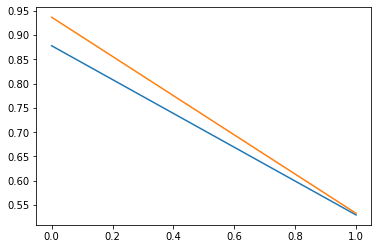

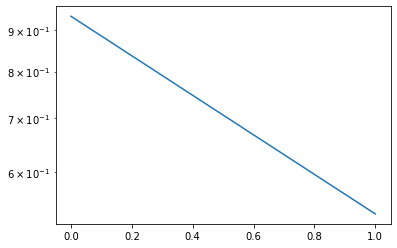

In [124]:
plt.plot(ltrain_tr1)
plt.plot(ltrain_tr2)
plt.show()

plt.semilogy(ltrain_tr2)
plt.show()

In [138]:
print("Study statistics: ")
print("Number of finished trials: ", len(study.trials))


print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


Study statistics: 
Number of finished trials:  5
Best trial:
  Value:  82.05666666666667
  Params: 
    optimizer: RMSprop
    lr: 0.002481014545692836


# KFOLD standard 
https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md

In [78]:
if __name__ == '__main__':
  
  # Configuration options
  k_folds = 2
  num_epochs = 1
  loss_function = nn.CrossEntropyLoss()
  
  # For fold results
  results = {}
  
  # Set fixed random number seed
  torch.manual_seed(42)
  
  # Prepare MNIST dataset by concatenating 
  #See above
  dataset = train_dataset


  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=k_folds, shuffle=True)
    
  # Start print
  print('--------------------------------')

  # K-fold Cross Validation model evaluation
  for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=10, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=10, sampler=test_subsampler)
    
    # Init the neural network
    network = SimpleConvNet()
    network.apply(reset_weights)
    
    # Initialize optimizer
    optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
    
    # Run the training loop for defined number of epochs
    for epoch in range(0, num_epochs):

      # Print epoch
      print(f'Starting epoch {epoch+1}')

      # Set current loss value
      current_loss = 0.0

      # Iterate over the DataLoader for training data
      for i, data in enumerate(trainloader, 0):
        
        # Get inputs
        inputs, targets = data
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Perform forward pass
        outputs = network(inputs)
        
        # Compute loss
        loss = loss_function(outputs, targets)
        
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        current_loss += loss.item()
        if i % 500 == 499:
            print('Loss after mini-batch %5d: %.3f' %
                  (i + 1, current_loss / 500))
            current_loss = 0.0
            
    # Process is complete.
    print('Training process has finished. Saving trained model.')

    # Print about testing
    print('Starting testing')
    
    # Saving the model
    save_path = f'./model-fold-{fold}.pth'
    torch.save(network.state_dict(), save_path)

    # Evaluationfor this fold
    correct, total = 0, 0
    with torch.no_grad():

      # Iterate over the test data and generate predictions
      for i, data in enumerate(testloader, 0):

        # Get inputs
        inputs, targets = data

        # Generate outputs
        outputs = network(inputs)

        # Set total and correct
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

      # Print accuracy
      print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
      print('--------------------------------')
      results[fold] = 100.0 * (correct / total)
    
  # Print fold results
  print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
  print('--------------------------------')
  sum = 0.0
  for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
  print(f'Average: {sum/len(results.items())} %')

--------------------------------
FOLD 0
--------------------------------
Reset trainable parameters of layer = Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Linear(in_features=6760, out_features=50, bias=True)
Reset trainable parameters of layer = Linear(in_features=50, out_features=20, bias=True)
Reset trainable parameters of layer = Linear(in_features=20, out_features=10, bias=True)
Starting epoch 1
Loss after mini-batch   500: 1.664
Loss after mini-batch  1000: 0.798
Loss after mini-batch  1500: 0.671
Loss after mini-batch  2000: 0.626
Loss after mini-batch  2500: 0.609
Loss after mini-batch  3000: 0.586
Training process has finished. Saving trained model.
Starting testing
Accuracy for fold 0: 80 %
--------------------------------
FOLD 1
--------------------------------
Reset trainable parameters of layer = Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
Reset trainable parameters of layer = Linear(in_features=6760, out_features=50, bias=Tru